scRNA-seq Example
-----------------------------------------------
Examples to use ``GSEApy`` for scRNA-seq data

In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
import gseapy as gp
import scanpy as sc

In [3]:
gp.__version__

'1.0.0'

### 1. Read Demo Data

In [4]:
adata = sc.read_h5ad("data/ifnb.h5ad") # data from SeuratData::ifnb

In [5]:
adata.obs.head()

,orig.ident,nCount_RNA,nFeature_RNA,stim,seurat_annotations
AAACATACATTTCC.1,IMMUNE_CTRL,3017.0,877,CTRL,CD14 Mono
AAACATACCAGAAA.1,IMMUNE_CTRL,2481.0,713,CTRL,CD14 Mono
AAACATACCTCGCT.1,IMMUNE_CTRL,3420.0,850,CTRL,CD14 Mono
AAACATACCTGGTA.1,IMMUNE_CTRL,3156.0,1109,CTRL,pDC
AAACATACGATGAA.1,IMMUNE_CTRL,1868.0,634,CTRL,CD4 Memory T


In [6]:
adata.layers['counts'] = adata.X # Save raw counts

In [7]:
# preprocessing
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['lognorm'] = adata.X

In [8]:
adata.obs.groupby('seurat_annotations')['stim'].value_counts()

seurat_annotations  stim
B                   STIM     571
                    CTRL     407
B Activated         STIM     203
                    CTRL     185
CD14 Mono           CTRL    2215
                    STIM    2147
CD16 Mono           STIM     537
                    CTRL     507
CD4 Memory T        STIM     903
                    CTRL     859
CD4 Naive T         STIM    1526
                    CTRL     978
CD8 T               STIM     462
                    CTRL     352
DC                  CTRL     258
                    STIM     214
Eryth               STIM      32
                    CTRL      23
Mk                  STIM     121
                    CTRL     115
NK                  STIM     321
                    CTRL     298
T activated         STIM     333
                    CTRL     300
pDC                 STIM      81
                    CTRL      51
Name: stim, dtype: int64

In [9]:
# set STIM as class 0, CTRL as class 1, to make categorical
adata.obs['stim'] = pd.Categorical(adata.obs['stim'], categories=["STIM", "CTRL"], ordered=True)
indices = adata.obs.sort_values(['seurat_annotations', 'stim']).index
adata = adata[indices,:]

In [ ]:
# # # subset and write GCT and CLS file
# outdir = "ifnb/"
# for cell in adata.obs.seurat_annotations.unique():
#     bdata = adata[adata.obs.seurat_annotations == cell ]
#     groups = bdata.obs['stim'].to_list()
#     cls_dict = bdata.obs['stim'].to_dict()
#     gs = bdata.to_df().T
#     gs.index.name = "NAME"
    
#     gs_std = gs.groupby(by=cls_dict, axis=1).std()
#     gs = gs[gs_std.sum(axis=1) > 0]
#     gs= gs + 1e-08  # we don't like zeros!!!
    
#     gs.insert(0, column="Description", value=cell,)
#     outname = os.path.join( outdir, cell + ".gct")
#     outcls = os.path.join(outdir, cell +".cls")
#     s_len = gs.shape[1] - 1
#     with open(outname,"w") as correct:
#         line1="#1.2\n"+f"{gs.shape[0]}\t{s_len}\n"
#         correct.write(line1)
#         gs.to_csv(correct, sep="\t")
        
#     with open(outcls, "w") as cl:
#         line = f"{len(groups)} 2 1\n# STIM CTRL\n"
#         cl.write(line)
#         cl.write(" ".join(groups) + "\n")
#     print(outname)

In [10]:
# subset data
bdata = adata[adata.obs.seurat_annotations == "CD14 Mono"].copy()
bdata

AnnData object with n_obs × n_vars = 4362 × 14053
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations'
    var: 'features'
    uns: 'log1p'
    layers: 'counts', 'lognorm'

### 2. GSEA 

In [11]:
import time
t1 = time.time()
res = gp.gsea(data=bdata.to_df().T, # row -> genes, column-> samples
        gene_sets="GO_Biological_Process_2021",
        cls=bdata.obs.stim,
        permutation_num=1000,
        permutation_type='phenotype', 
        outdir=None,
        method='s2n', # signal_to_noise
        threads= 16)
t2=time.time()
print(t2-t1)

81.40560293197632


In [12]:
res.res2d.head(10)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,cytokine-mediated signaling pathway (GO:0019221),0.685491,3.759972,0.0,0.0,0.0,140/490,9.03%,ISG15;IFIT3;IFIT1;RSAD2;ISG20;CXCL10;IFITM3;CX...
1,gsea,innate immune response (GO:0045087),0.784391,3.66143,0.0,0.0,0.0,56/188,6.30%,ISG15;IFIT1;CXCL10;IFITM3;APOBEC3A;MX1;IFI6;OA...
2,gsea,regulation of immune response (GO:0050776),0.759354,3.549856,0.0,0.0,0.0,49/140,8.77%,RSAD2;IRF7;PLSCR1;HERC5;IL4I1;SLAMF7;IFITM1;HL...
3,gsea,defense response to virus (GO:0051607),0.903464,3.438759,0.0,0.0,0.0,42/108,2.85%,ISG15;IFIT3;IFIT1;RSAD2;ISG20;CXCL10;IFITM3;AP...
4,gsea,response to cytokine (GO:0034097),0.718931,3.37735,0.0,0.0,0.0,37/120,7.26%,ISG15;IFITM3;MX1;IFITM2;PLSCR1;MX2;BST2;EIF2AK...
5,gsea,defense response to symbiont (GO:0140546),0.904717,3.362051,0.0,0.0,0.0,49/100,4.90%,ISG15;IFIT3;IFIT1;RSAD2;ISG20;IFITM3;APOBEC3A;...
6,gsea,cellular response to interferon-gamma (GO:0071...,0.792726,3.327923,0.0,0.0,0.0,49/99,7.18%,CCL8;OAS1;MT2A;OASL;IRF7;GBP1;GBP4;CCL2;OAS3;O...
7,gsea,regulation of interferon-beta production (GO:0...,0.856704,3.259412,0.0,0.0,0.0,14/44,4.94%,ISG15;OAS1;IRF7;DDX58;IFIH1;OAS3;OAS2;DHX58;HS...
8,gsea,"RNA splicing, via transesterification reaction...",-0.626583,-3.225436,0.0,0.0,0.0,128/234,19.45%,YBX1;PABPC1;HNRNPA1;DDX5;SRSF9;HNRNPM;RBMX;SF3...
9,gsea,gene expression (GO:0010467),-0.70455,-3.219153,0.0,0.0,0.0,134/322,10.13%,RPL6;RPL7;RPL15;RPL10;RPS3A;RPS6;RPL8;RPL21;RP...


In [13]:
res.ranking.shape # raking metric

(13216,)

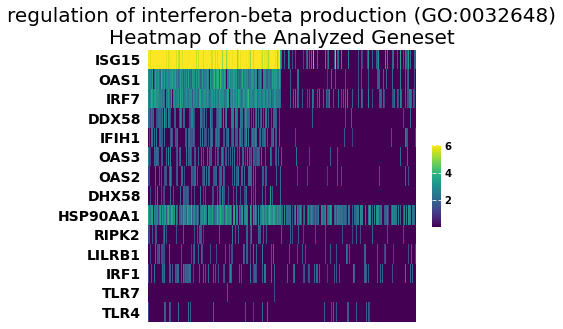

In [14]:
## Heatmap of gene expression
i = 7
genes = res.res2d.Lead_genes.iloc[i].split(";")
gp.heatmap(df = res.heatmat.loc[genes], 
           z_score=None, 
           title=res.res2d.Term.iloc[i], 
           figsize=(6,5), 
           cmap=plt.cm.viridis, 
           xticklabels=False)

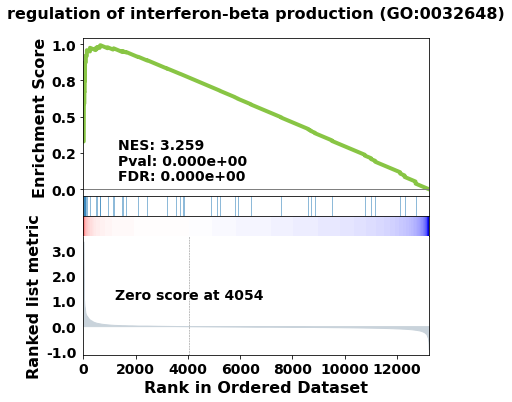

In [32]:
term = res.res2d.Term.iloc[i]
gp.gseaplot(res.ranking, term=term, **res.results[term])

### 3. DEG Analysis

In [16]:
# find degs 
sc.tl.rank_genes_groups(bdata, groupby='stim', use_raw=False, layer='lognorm', method='wilcoxon', groups=["STIM"], reference='CTRL')

In [17]:
bdata.X.max() # already log1p

8.065909516515664

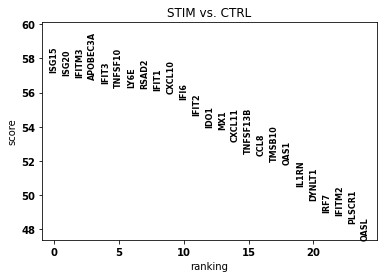

In [18]:
sc.pl.rank_genes_groups(bdata, n_genes=25, sharey=False)

In [19]:
# get deg result
result = bdata.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names','scores', 'pvals','pvals_adj','logfoldchanges']})

In [20]:
degs.head()

,STIM_names,STIM_scores,STIM_pvals,STIM_pvals_adj,STIM_logfoldchanges
0,ISG15,57.165920,0.0,0.0,8.660480
1,ISG20,57.010372,0.0,0.0,6.850681
2,IFITM3,56.890392,0.0,0.0,6.320490
3,APOBEC3A,56.770397,0.0,0.0,6.616682
4,IFIT3,56.569122,0.0,0.0,8.313443


In [21]:
degs.shape

(14053, 5)

### 4. Over-representation analysis (Enrichr API)

In [22]:
# subset up or down regulated genes
degs_sig = degs[degs.STIM_pvals_adj < 0.05]
degs_up = degs_sig[degs_sig.STIM_logfoldchanges > 0]
degs_dw = degs_sig[degs_sig.STIM_logfoldchanges < 0]

In [23]:
degs_up.shape

(687, 5)

In [24]:
degs_dw.shape

(1030, 5)

In [33]:
# Enricr API
enr_up = gp.enrichr(degs_up.STIM_names, 
                    gene_sets='GO_Biological_Process_2021', 
                    outdir=None)

In [34]:
# trim (go:...)
enr_up.res2d.Term = enr_up.res2d.Term.str.split(" \(GO").str[0]

<AxesSubplot:title={'center':'Up'}, xlabel='Combined Score'>

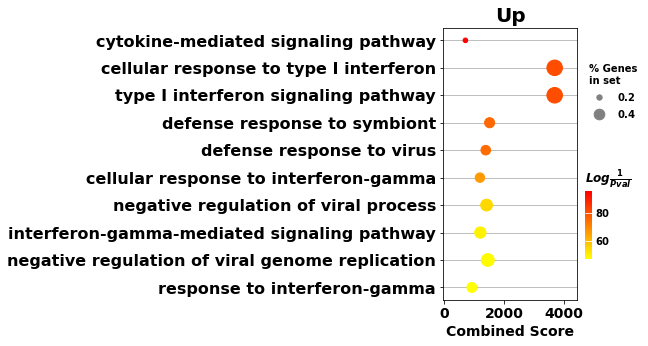

In [35]:
# dotplot
gp.dotplot(enr_up.res2d, figsize=(3,5), title="Up", cmap = plt.cm.autumn_r)
plt.show()

In [36]:
enr_dw = gp.enrichr(degs_dw.STIM_names, gene_sets='GO_Biological_Process_2021', outdir=None)

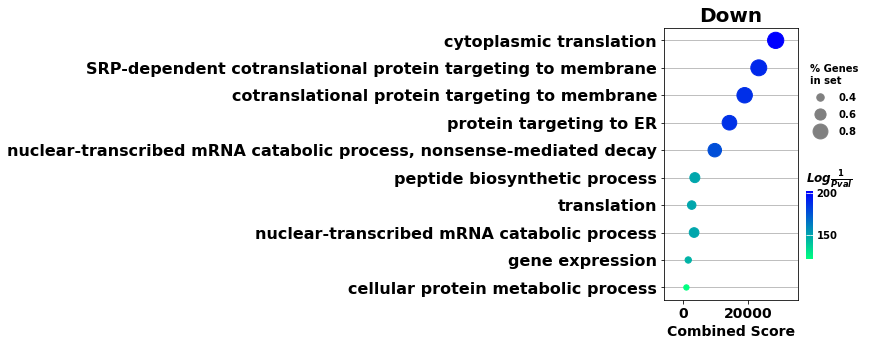

In [37]:
enr_dw.res2d.Term = enr_dw.res2d.Term.str.split(" \(GO").str[0]
gp.dotplot(enr_dw.res2d, figsize=(3,5), title="Down", cmap = plt.cm.winter_r, size=7)
plt.show()

In [38]:
# concat results
enr_up.res2d['UP_DW'] = "UP"
enr_dw.res2d['UP_DW'] = "DOWN"
enr_res = pd.concat([enr_up.res2d.head(), enr_dw.res2d.head()]) 

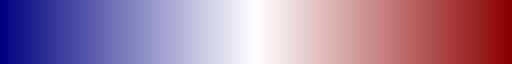

In [41]:
from gseapy.scipalette import SciPalette
sci = SciPalette()
NbDr = sci.create_colormap()
NbDr

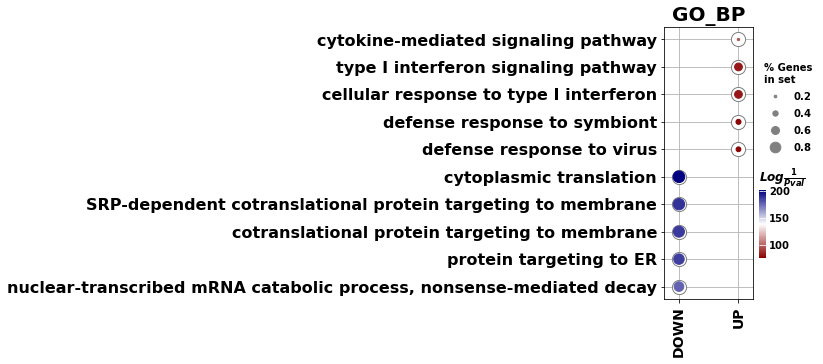

In [45]:

ax = gp.ringplot(enr_res,figsize=(2,5), x='UP_DW', title="GO_BP", cmap = NbDr.reversed(), size=5)

### 5. Network Visualization

In [50]:
import networkx as nx

In [46]:
res.res2d.head()

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,cytokine-mediated signaling pathway (GO:0019221),0.685491,3.759972,0.0,0.0,0.0,140/490,9.03%,ISG15;IFIT3;IFIT1;RSAD2;ISG20;CXCL10;IFITM3;CX...
1,gsea,innate immune response (GO:0045087),0.784391,3.66143,0.0,0.0,0.0,56/188,6.30%,ISG15;IFIT1;CXCL10;IFITM3;APOBEC3A;MX1;IFI6;OA...
2,gsea,regulation of immune response (GO:0050776),0.759354,3.549856,0.0,0.0,0.0,49/140,8.77%,RSAD2;IRF7;PLSCR1;HERC5;IL4I1;SLAMF7;IFITM1;HL...
3,gsea,defense response to virus (GO:0051607),0.903464,3.438759,0.0,0.0,0.0,42/108,2.85%,ISG15;IFIT3;IFIT1;RSAD2;ISG20;CXCL10;IFITM3;AP...
4,gsea,response to cytokine (GO:0034097),0.718931,3.37735,0.0,0.0,0.0,37/120,7.26%,ISG15;IFITM3;MX1;IFITM2;PLSCR1;MX2;BST2;EIF2AK...


In [47]:
df = res.res2d
df['Lead_genes2'] = df.Lead_genes.str.split(";")

In [48]:
## build edges
num_nodes = len(df)

In [98]:
# build graph
G = nx.Graph()
edges_dict = {}
gene_col_indx = 10 # Lead_genes2
for i in range(num_nodes):
    for j in range(i+1, num_nodes):
        set_i = set(df.iloc[i, gene_col_indx])
        set_j = set(df.iloc[j, gene_col_indx])
        ov = set_i.intersection(set_j)
        jaccard_coefficient = len(ov) / len(set_i.union(set_j))
        overlap_coefficient = len(ov) / min(len(set_i), len(set_j))
        edges_dict[(i, j)] = [jaccard_coefficient, overlap_coefficient, list(ov)]
        src = df.iloc[i, 1]
        targ = df.iloc[j, 1]
        G.add_edge(src, targ, jaccard= jaccard_coefficient, overlap = overlap_coefficient, genes = list(ov))

In [55]:
df['NOM p-val'] = df['NOM p-val'].clip(1e-4, 1.0)
df['p_inv'] = df.apply(lambda x: np.log(x['NOM p-val'])*np.sign(x['NES']), axis=1)

In [91]:
# subset df
df2 = df[(df['FDR q-val'] < 1e-9) & (df['NES'].abs() > 2)] # 
df2 = df2.sample(20)
df2 = df2.reindex()

In [92]:
G1 = G.subgraph(df2.Term.to_list())

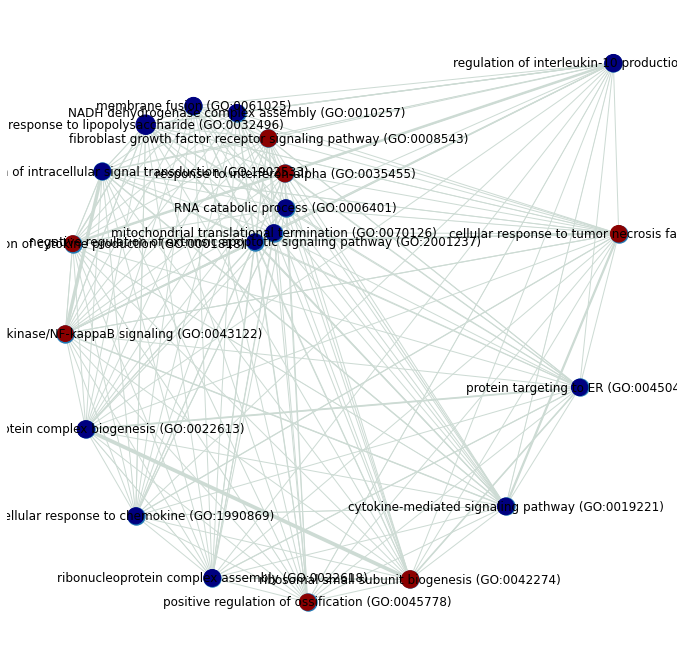

In [97]:
fig, ax = plt.subplots(figsize=(12,12))
pos=nx.layout.spiral_layout(G1)
nx.draw(G1, pos=pos, with_labels = True, edge_color='#CDDBD4')
edge_weight = nx.get_edge_attributes(G1, 'jaccard').values()
#node_size = nx.get_node_attributes()
node_size = list(df2.NES.abs() *100)
node_color =  df2.p_inv.to_list()
node_labels = df2.Term.to_list()
nx.draw_networkx_nodes(G1, pos=pos, node_size=node_size, node_color=node_color, cmap=NbDr)
nx.draw_networkx_edges(G1, pos=pos, width=list(map(lambda x: x*10, edge_weight)), edge_color='#CDDBD4')
plt.show()